# Задача 5.1.

---
Дана выборка: https://github.com/andriygav/PSAD/blob/master/labs/lab1/data/regression.zip

Выборка состоит из трех обзектов: X_train, Y_train, X_test

Y_train - изображение (пиксель кодируется черно-белой компонентой изображения), X_train - признаки, соответствующие этому изображению. (элемент X[i,j] соответствует набору признаков для пикселя Y[i,j]).

Требуется:

1. Провести отбор наиболее значимых признаков и построить регрессию X->Y
2. Проинтерпетировать признаки (каждый признак является функцией, возможно нелинейной, от значения пикселя)
3. Получить изображение по X_test (оцениваться будет качество полученного изображения. Ожидается, что регрессия на X_train, Y_train даст R^2>0.85).

---

In [198]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import statsmodels.formula.api as smf

### 1. Загрузим данные:

In [171]:
X_train = np.load('regression/regression_x_train.npy')
y_train = np.load('regression/regression_y_train.npy')
X_test = np.load('regression/regression_x_test.npy')

In [172]:
train_size = X_train.shape[:2]

In [173]:
test_size = X_test.shape[:2]

Выведем картинку, соответствующую y_train:

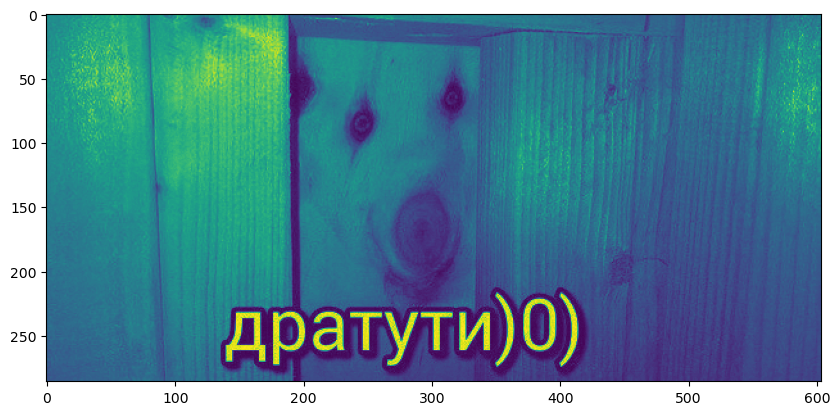

In [174]:
fig, ax = plt.subplots(1, 1, figsize=(10,5))

ax.imshow(y_train)

None

### 2. Преобразуем данные к нужному формату и совершим отбор признаков:

1. Приведем данные из формата 3-мерных тензоров к табличным данным для удобства:

In [175]:
X_train = np.reshape(X_train, (X_train.shape[0] * X_train.shape[1], X_train.shape[2]))
y_train = np.reshape(y_train, (y_train.shape[0] * y_train.shape[1],))
X_test = np.reshape(X_test, (X_test.shape[0] * X_test.shape[1], X_test.shape[2]))

X_train = pd.DataFrame(X_train)
X_test =  pd.DataFrame(X_test)

2. Найдем useless переменные:

In [176]:
useless_cols = []
for col in X_train.columns:
    if X_train[col].unique().shape[0]==1:
        useless_cols.append(col)
        
print(f'Useless cols: {useless_cols}')

Useless cols: [30, 31, 32, 33, 34]


Удалим их:

In [177]:
X_train.drop(columns = useless_cols, inplace=True)
X_test.drop(columns = useless_cols, inplace=True)

3. Приведем данные к единому формату с помощью MinMaxScaler:

In [178]:
scaler = MinMaxScaler()
scaler.fit(X_train)

X_train = pd.DataFrame(scaler.transform(X_train))
X_test = pd.DataFrame(scaler.transform(X_test))

4. Посмотрим на скоррелированные/дублированные фичи:

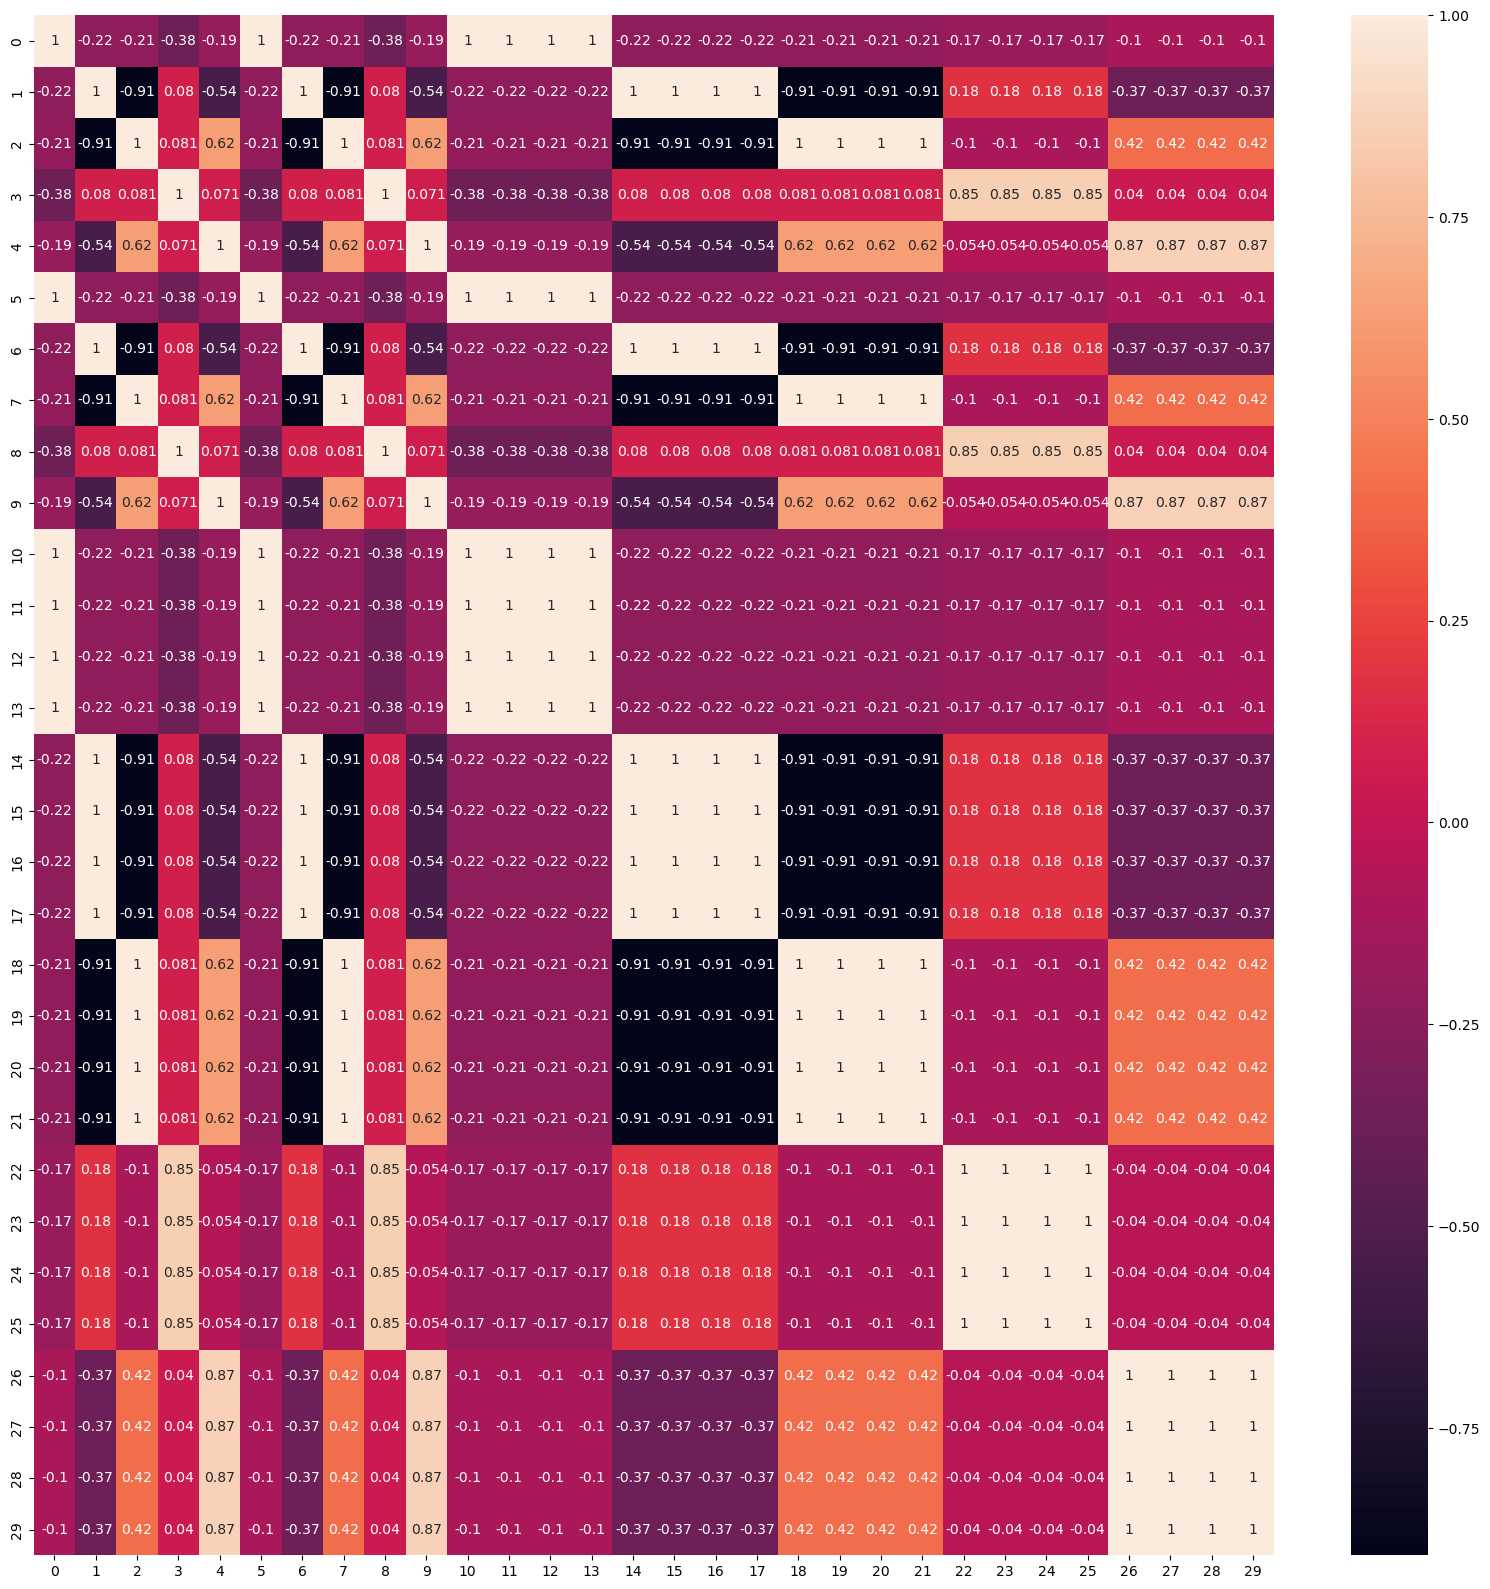

In [156]:
fig, ax = plt.subplots(1, 1, figsize=(20,20))
ax = sns.heatmap(X_train.corr(), annot=True)

Посмотрев на тепловую карту, можно вычислить дубли и сильно скоррелированные фичи. Уберем их:

In [179]:
cols_to_drop = [5,10,11,12,13,6,14,15,16,17,7,18,19,20,21,8,9,23,24,25,27,28,29]

In [180]:
X_train.drop(columns=cols_to_drop, inplace=True)
X_test.drop(columns=cols_to_drop, inplace=True)

Изобразим heatmap на оставшихся фичах:

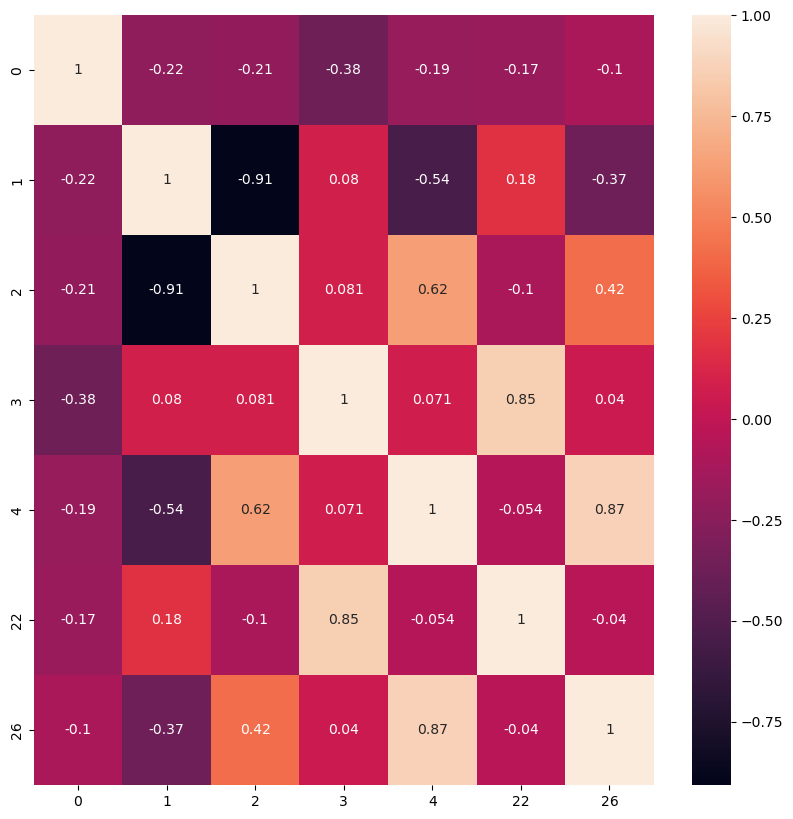

In [181]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
ax = sns.heatmap(X_train.corr(), annot=True)

### 3. Интерпретация оставшихся признаков

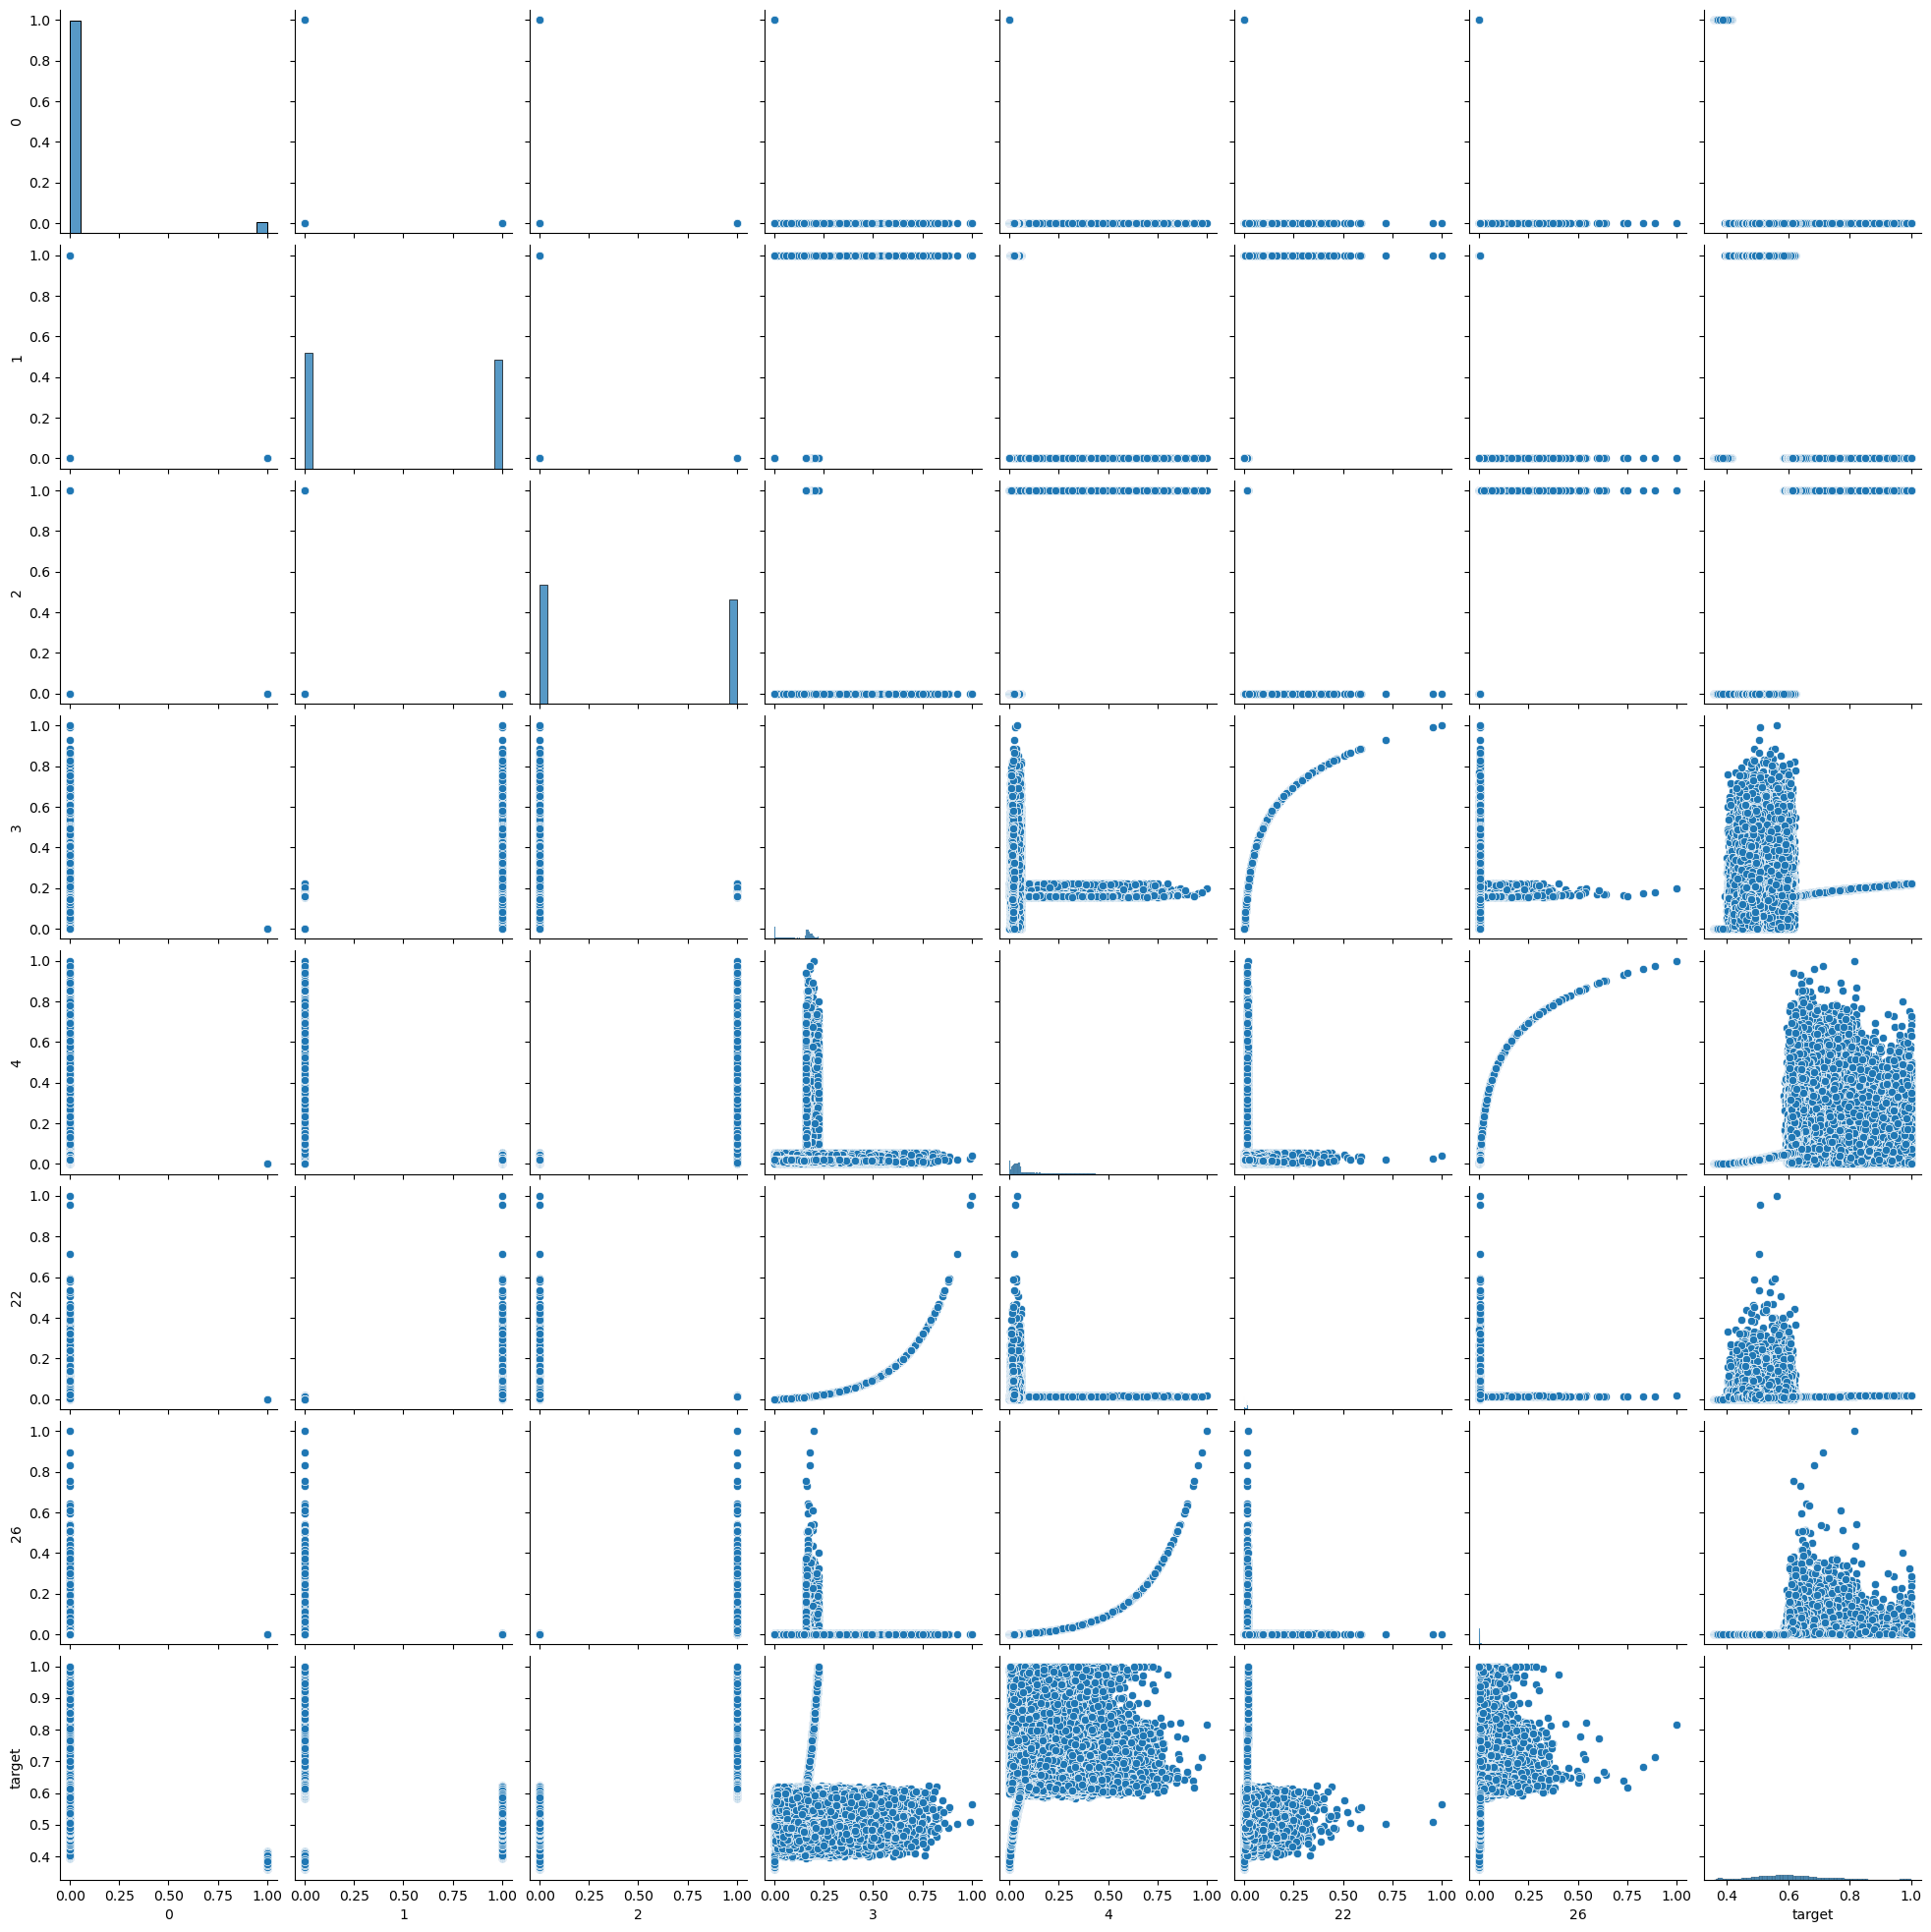

In [160]:
y_train_df = pd.DataFrame(y_train)
y_train_df.columns = ['target']
train_df = pd.concat((X_train, y_train_df), axis=1)

sns.pairplot(train_df)

None

### 4. Обучение  линейной регрессии 

In [188]:
X_train = X_train.rename(columns = {i: f'X{i}' for i in range(0, 5)})

In [195]:
model = smf.ols('target ~ X1 + X2 + X3 + X4 + X2:X4 + X2:X3 + X1:X3',
                data=pd.concat((X_train, y_train_df), axis=1)).fit()

In [196]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 target   R-squared:                       0.992
Model:                            OLS   Adj. R-squared:                  0.992
Method:                 Least Squares   F-statistic:                 3.111e+06
Date:                Sun, 09 Apr 2023   Prob (F-statistic):               0.00
Time:                        19:53:24   Log-Likelihood:             5.4514e+05
No. Observations:              172744   AIC:                        -1.090e+06
Df Residuals:                  172736   BIC:                        -1.090e+06
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.3824      0.000   3383.919      0.000       0.382       0.383
X1             0.0431      0.000    279.193      0.000       0.043       0.043
X2            -0.6607      0.000  -1463.579      0.000      -0.662      -0.660
X3         -1.193e+07   3.58e+09     -0.003      0.997   -7.03e+09       7e+09
X4             3.3628      0.002   1352.648      0.000       3.358       3.368
X2:X4         -3.3625      0.003  -1344.640      0.000      -3.367      -3.358
X2:X3       1.193e+07   3.58e+09      0.003      0.997      -7e+09    7.03e+09
X1:X3       1.193e+07   3.58e+09      0.003      0.997      -7e+09    7.03e+09
==============================================================================
Omnibus:                    28470.191   Durbin-Watson:                   1.236
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            97201.677
Skew:                           0.828   Prob(JB):                         0.00
Kurtosis:                       6.281   Cond. No.                     3.08e+14
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.76e-24. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

### 5. Предсказание на тесте

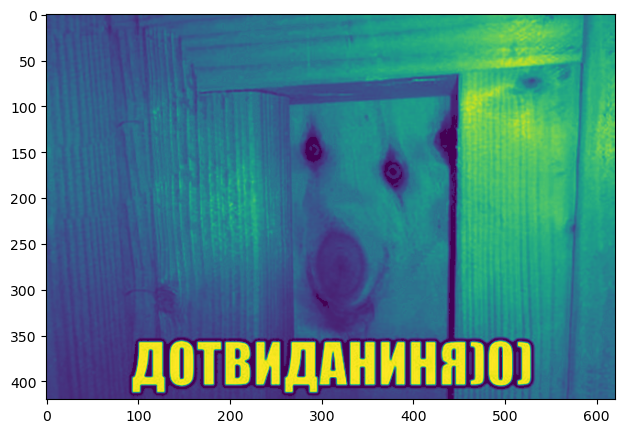

In [197]:
y_pred = np.array(model.predict(X_test.rename(columns = {i: f'X{i}' for i in range(0, 5)})))

fig, ax = plt.subplots(1, 1, figsize=(10,5))
ax.imshow(y_pred.reshape(test_size))

None